In [1]:
include("../src/KagomeTransport.jl");
using .KagomeTransport.Kagome_Hamiltonian;
using LinearAlgebra;
using StaticArrays;
using Makie
using CairoMakie
using Printf


## Useful functions for generating loops an paths in momentum space. The limits of the paths are given by lim * pi ##

In [30]:
function construct_kloop(nk::Int64, lim::Float64)
    """
    Construct a loop in the k-space
    """
    lim *= pi 
    # ky = - pi * lim 
    L1 = [[x, -lim] for x ∈ LinRange(-lim, lim, nk)]
    pop!(L1)
    # kx = pi * lim 
    L2 = [[lim, y] for y ∈ LinRange(-lim, lim, nk)]
    pop!(L2) 
    # ky = pi * lim  
    L3 = [[x, lim] for x ∈ LinRange(lim, -lim, nk)]
    pop!(L3)
    # kx = -pi * lim 
    L4 = [[-lim, y] for y ∈ LinRange(lim, -lim, nk)]
    
    # Concatenate all the segments to form loop 
    L::Vector{Vector{Float64}} = [L1; L2; L3; L4]
    return L
end

function construct_kline(nk::Int64, lim::Float64; kx = nothing, ky = nothing)
    """
    Construct a line in the k-space
    """
    lim *= pi
    if kx == nothing && ky == nothing
        println("Please provide either kx or ky")
        return
    end
    if kx != nothing
        L = [[kx, y] for y ∈ LinRange(-lim, lim, nk)]
    elseif ky != nothing
        L = [[x, ky] for x ∈ LinRange(-lim, lim, nk)]
    end
    L
end

function plot_kpath(path)
    """
    Plot the path in the momentum space. 
    """
    xs = [k[1] for k ∈ path]
    ys = [k[2] for k ∈ path]
    fig = Figure()
    ax = Axis(fig[1, 1], title = "Path in the momentum space. ")
    scatter!(ax, xs, ys, markersize = 10, color = :darkblue)
    ax.xlabel = L"k_x"
    ax.ylabel = L"k_y"
    display(fig)
end


## Chern Number and Berry Curvature Calculations for the Dirac Fermion ## 

In [31]:

# Here, we first define the necessary functions for the Dirac Fermion Hamiltonian, and the velocity matrices 
function eigensystem_dirac_fermion(k::Vector{Float64}, M::Float64)
    """
    Returns the eigenvalues and eigenvectors of the Dirac Fermion Hamiltonian
    """
    kz = k[1] - im * k[2]; kzc = k[1] + im * k[2]
    eigen([M kz; kzc -M])
end
function velx_DF()
    """
    Returns the x-velocity operator for the Dirac Fermion Hamiltonian
    """
    [0.0 1.0; 1.0 0.0]
end

function vely_DF()
    """
    Returns the y-velocity operator for the Dirac Fermion Hamiltonian
    """
    [0.0 -im; im 0.0]
end

# Implementation of the Wilson loop method for the Dirac Fermion calculation  

function Wilson_Loop(line::Vector{Vector{Float64}}, M::Float64, band::Int64)
    """
    Nonsense function, fix it later.
    Wilson Loop Calculation:
    First, we need to calculate the Wilson loop spectra. 
    """
    nk = size(line, 1)
    println("Number of points along the loop: ", nk)
    prod::ComplexF64 = 1.0 + 0.0im 
    for n ∈ 1 : nk
        kn = line[n]
        knnext = line[mod1(n + 1, nk)]
        (En, Un) = eigensystem_dirac_fermion(kn, M)
        (Ennext, Unnext) = eigensystem_dirac_fermion(knnext, M)
        fact = Unnext' * Un
        prod *= fact
    end
    prod
end


@inline function Berry_Curvature_DF(
    k::Vector{Float64}, 
    M::Float64,
    band::Int64)

    (E, U) = eigensystem_dirac_fermion(k, M)
    ωmn = E' .- E
    ωmn[ωmn .== 0] .= 1e-8

    Velx_b::Matrix{ComplexF64} = U' * velx_DF() * U
    Vely_b::Matrix{ComplexF64} = U' * vely_DF() * U
    
    setindex!.(Ref(Velx_b), 0.0 + im * 0.0, 1:2, 1:2)
    setindex!.(Ref(Vely_b), 0.0 + im * 0.0, 1:2, 1:2)

    Xmn_x = -im * (Velx_b ./ ωmn); Xmn_y = -im * (Vely_b ./ ωmn);
    -2.0 * imag.(Xmn_x * Xmn_y)[band, band]
end


function plot_berry_curvature_dirac_fermion(lim::Float64, nps::Int64, M::Float64)
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, nps)
    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end 
    res::Matrix{Float64} = Berry_Curvature_DF.(grid, Ref(M), 2);

    f = Figure()
    ax = Axis(f[1, 1], title="Berry Curvature for Band 1")
    m = heatmap!(ax, res, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end

function chern_number_dirac_fermion(lim::Float64, nps::Int64, M::Float64)
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, nps)

    # Normalization 
    area = 4.0 * pi * pi
    measure = area / (nps * nps)
    prefact = 1.0 / (2.0 * pi)
    total_fact = prefact * measure 

    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end 

    res::Matrix{Float64} = Berry_Curvature_DF.(grid, Ref(M), 2);

    # Total 
    sum(res) * total_fact
end

chern_number_dirac_fermion (generic function with 1 method)

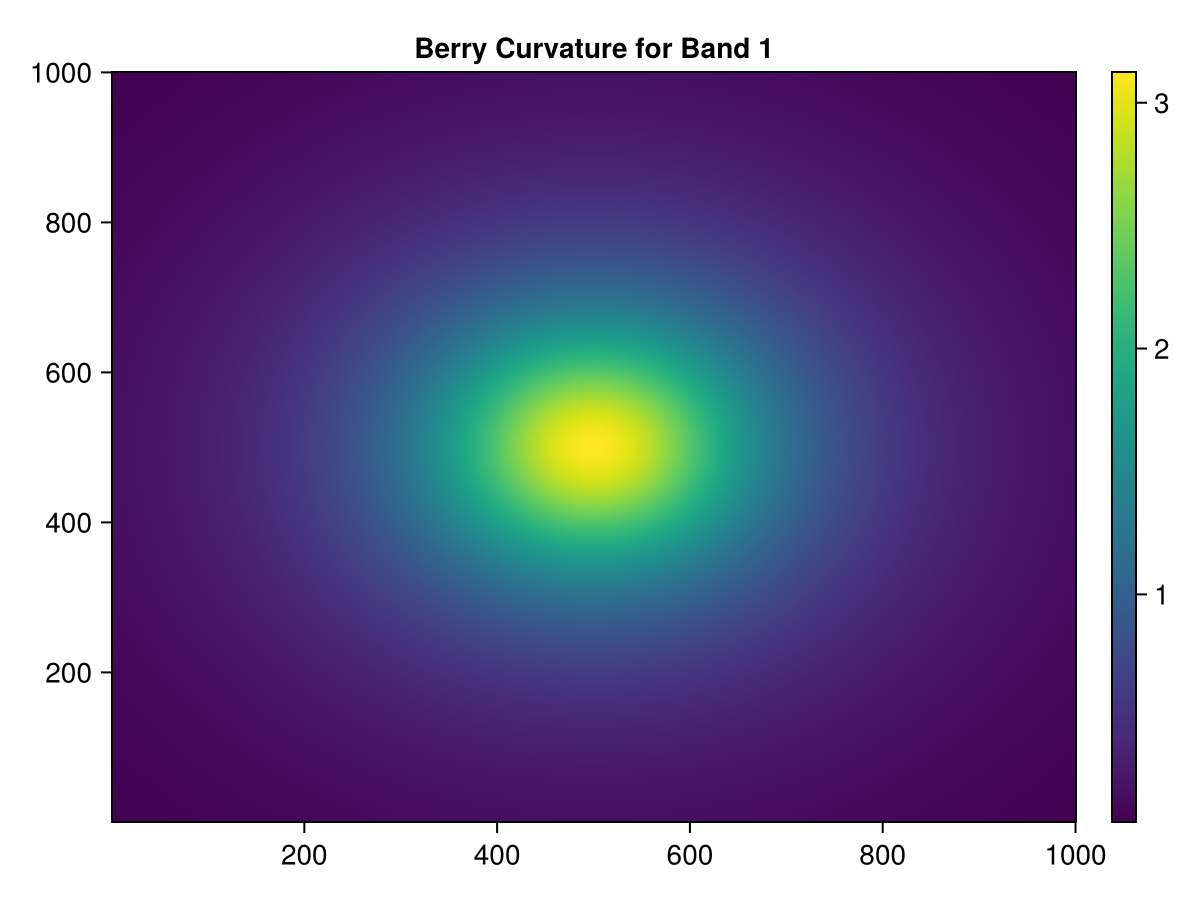

In [32]:
plot_berry_curvature_dirac_fermion(0.3, 1000, -0.4)

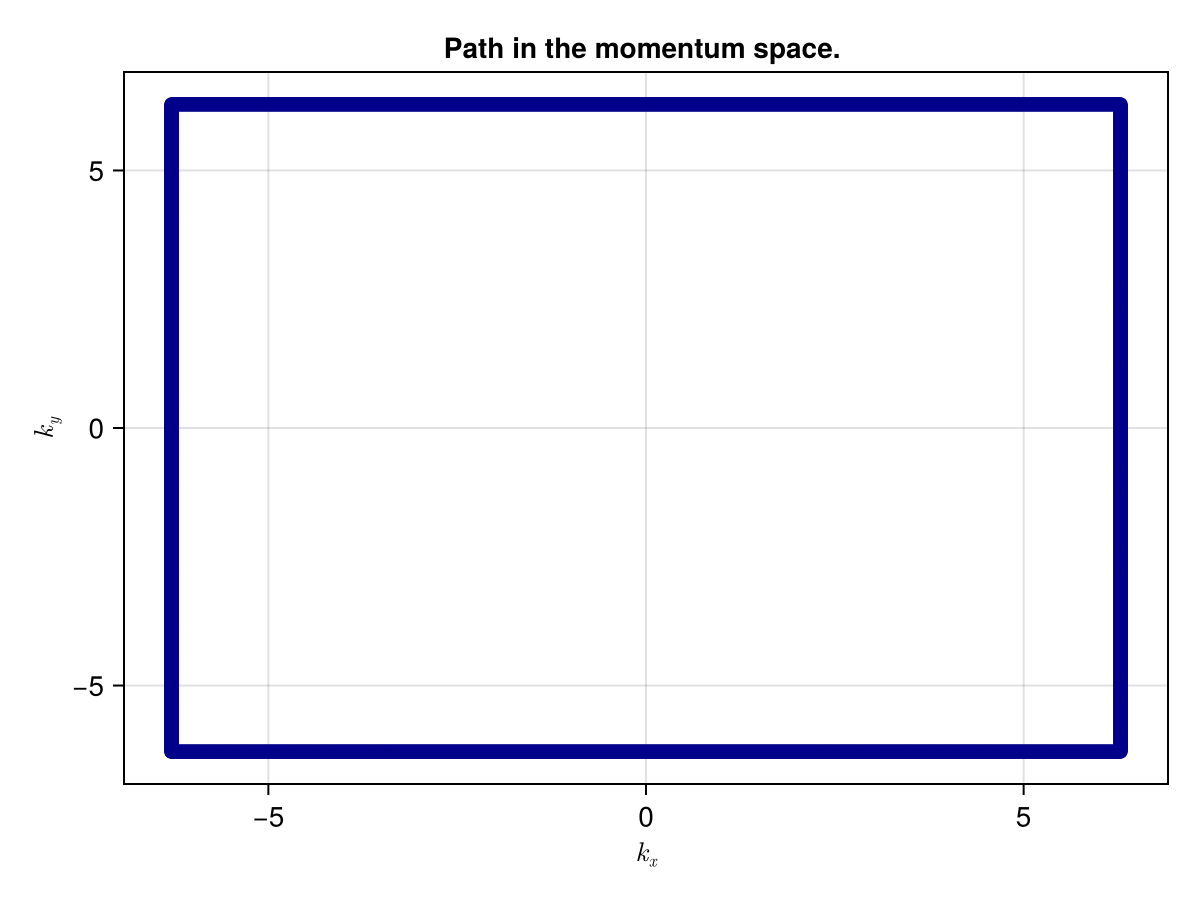

CairoMakie.Screen{IMAGE}


In [33]:
loop = construct_kloop(1000, 2.0); 
plot_kpath(loop)

In [37]:
"""
Calculate the xy comp. of the complex quantum metric (both the real quantum geometry and berry curvature of the bands at a single point in the BZ)
"""
@inline function Complex_Metric_xy(;
    E::Vector{Float64}, 
    U::Matrix{ComplexF64}, 
    Vxb::Matrix{ComplexF64}, 
    Vyb::Matrix{ComplexF64},
    Num_Bands::Int64)
    
    ωmn = E' .- E
    ωmn[ωmn .== 0] .= 1e-15
    
    setindex!.(Ref(Vxb), 0.0 + im * 0.0, 1:Num_Bands, 1:Num_Bands)
    setindex!.(Ref(Vyb), 0.0 + im * 0.0, 1:Num_Bands, 1:Num_Bands)

    Xmn_x = -im * (Vxb ./ ωmn); Xmn_y = -im * (Vyb ./ ωmn);
    Xmn_x * Xmn_y
end


@inline function Complex_Metric_xy(
    k::Vector{Float64}, 
    p::Params)

    Num_Bands::Int64 = 3

    (E, U) = eigensystem3c(k, p)
    ωmn = E' .- E
    ωmn[ωmn .== 0] .= 1e-15

    Velx_band::Matrix{ComplexF64} = U' * Velx(k[1], k[2], p) * U
    Vely_band::Matrix{ComplexF64} = U' * Vely(k[1], k[2], p) * U
    
    setindex!.(Ref(Velx_band), 0.0 + im * 0.0, 1:Num_Bands, 1:Num_Bands)
    setindex!.(Ref(Vely_band), 0.0 + im * 0.0, 1:Num_Bands, 1:Num_Bands)

    Xmn_x = -im * (Velx_band ./ ωmn); Xmn_y = -im * (Vely_band ./ ωmn);
    Xmn_x * Xmn_y'
end


@inline function Complex_Metric_xx(
    k::Vector{Float64}, 
    p::Params)

    Num_Bands::Int64 = 3

    (E, U) = eigensystem3c(k, p)
    ωmn = E' .- E
    ωmn[ωmn .== 0] .= 1e-15

    Velx_band::Matrix{ComplexF64} = U' * Velx(k[1], k[2], p) * U
    
    setindex!.(Ref(Velx_band), 0.0 + im * 0.0, 1:Num_Bands, 1:Num_Bands)

    Xmn_x = -im * (Velx_band ./ ωmn)
    Xmn_x * Xmn_x'
end


@inline function Complex_Metric_yy(
    k::Vector{Float64}, 
    p::Params)

    Num_Bands::Int64 = 3

    (E, U) = eigensystem3c(k, p)
    ωmn = E' .- E
    ωmn[ωmn .== 0] .= 1e-15

    Vely_band::Matrix{ComplexF64} = U' * Vely(k[1], k[2], p) * U
    
    setindex!.(Ref(Vely_band), 0.0 + im * 0.0, 1:Num_Bands, 1:Num_Bands)

    Xmn_y = -im * (Vely_band ./ ωmn)
    Xmn_y * Xmn_y'
end


@inline function Berry_Curvature(
    k::Vector{Float64}, 
    p::Params,
    band::Int64)

    Num_Bands::Int64 = 3

    (E, U) = eigensystem3c(k, p)
    ωmn = E' .- E
    ωmn[ωmn .== 0] .= 1e-15

    Velx_band::Matrix{ComplexF64} = U' * Velx(k[1], k[2], p) * U
    Vely_band::Matrix{ComplexF64} = U' * Vely(k[1], k[2], p) * U
    
    setindex!.(Ref(Velx_band), 0.0 + im * 0.0, 1:Num_Bands, 1:Num_Bands)
    setindex!.(Ref(Vely_band), 0.0 + im * 0.0, 1:Num_Bands, 1:Num_Bands)

    Xmn_x = -im * (Velx_band ./ ωmn); Xmn_y = -im * (Vely_band ./ ωmn);
    2.0 * imag.(Xmn_x * Xmn_y)[band, band]
end




Berry_Curvature (generic function with 1 method)

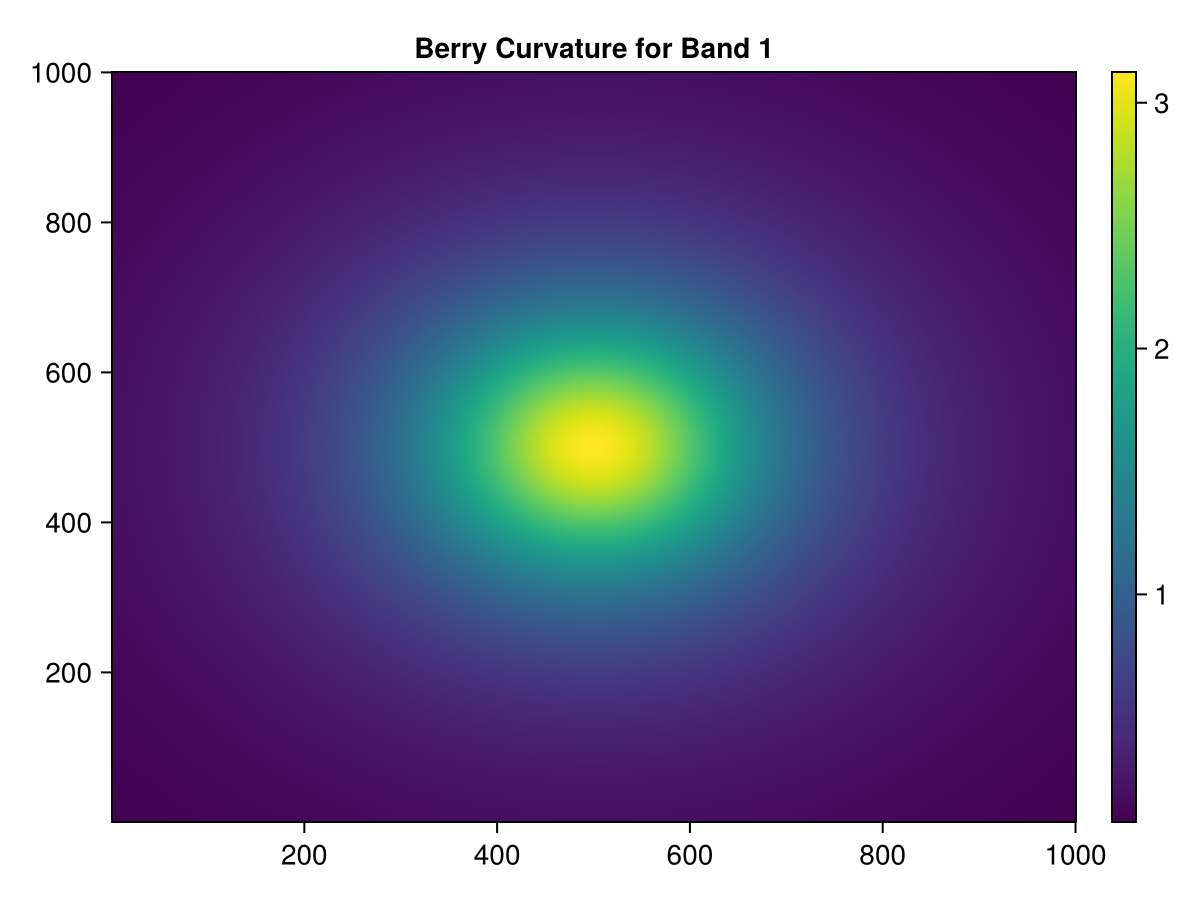

In [38]:
plot_berry_curvature_dirac_fermion(0.3, 1000, -0.4)

In [ ]:
chern_number_dirac_fermion(0.3, 1000, -0.4)

In [ ]:
pi / 2

In [ ]:
# Preliminary calculation of the Berry curvature 
let npts_perdim = 300, lim = 2.0, t1 = -1.0, u1 = 1.0, t2 = 0.0, u2 = 0.0
    p = Params(t1 = t1, u1 = u1, t2 = t2, u2 = u2)
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end    

    res::Matrix{Matrix{ComplexF64}} = Complex_Metric_xy.(grid, Ref(p));
    res_1 = map(x -> x[1, 1], res)
    res_2 = map(x -> x[2, 2], res)
    res_3 = map(x -> x[3, 3], res)

    # Berry curvature of the bands
    F_1 = imag.(res_1); F_2 = imag.(res_2); F_3 = imag.(res_3)
    
    f = Figure()
    ax = Axis(f[1, 1], title="Berry Curvature for Band 1")
    m = heatmap!(ax, F_1, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


In [ ]:
# Preliminary calculation of the Berry curvature 
let npts_perdim = 300, lim = 2.0, t1 = -1.0, u1 = 0.28, t2 = 0.3, u2 = 0.2
    p = Params(t1 = t1, u1 = u1, t2 = t2, u2 = u2)
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end    

    res::Matrix{Matrix{ComplexF64}} = Complex_Metric_xy.(grid, Ref(p));
    res_1 = map(x -> x[1, 1], res)
    res_2 = map(x -> x[2, 2], res)
    res_3 = map(x -> x[3, 3], res)

    # Berry curvature of the bands
    F_1 = imag.(res_1); F_2 = imag.(res_2); F_3 = imag.(res_3)
    
    f = Figure()
    ax = Axis(f[1, 1], title="Berry Curvature for Band 1")
    m = heatmap!(ax, F_1, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


In [ ]:
# NOTE: The Flat Band is the top band i.e. Band # 3 when t1 = -1.0, u1 = 0.0, t2 = 0.0, u2 = 0.0  
let npts_perdim = 300, lim = 2.0, t1 = -1.0, u1 = 0.0, t2 = 0.0, u2 = 0.0
    p = Params(t1 = t1, u1 = u1, t2 = t2, u2 = u2)
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end    

    res::Matrix{Matrix{ComplexF64}} = Complex_Metric_xy.(grid, Ref(p));
    res_1 = map(x -> x[1, 1], res)
    res_2 = map(x -> x[2, 2], res)
    res_3 = map(x -> x[3, 3], res)

    # Berry curvature of the bands
    F_1 = imag.(res_1); F_2 = imag.(res_2); F_3 = imag.(res_3)
    
    f = Figure()
    ax = Axis(f[1, 1], title="Berry Curvature for Band 1")
    m = heatmap!(ax, F_3, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


In [ ]:
# NOTE: The Flat Band is the top band i.e. Band # 3 when t1 = -1.0, u1 = 0.0, t2 = 0.0, u2 = 0.0  
let npts_perdim = 300, lim = 2.0, t1 = -1.0, u1 = 0.2, t2 = 0.0, u2 = 0.0
    p = Params(t1 = t1, u1 = u1, t2 = t2, u2 = u2)
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end    

    res::Matrix{Matrix{ComplexF64}} = Complex_Metric_xy.(grid, Ref(p));
    res_1 = map(x -> x[1, 1], res)
    res_2 = map(x -> x[2, 2], res)
    res_3 = map(x -> x[3, 3], res)

    # Berry curvature of the bands
    F_1 = imag.(res_1); F_2 = imag.(res_2); F_3 = imag.(res_3)
    
    f = Figure()
    ax = Axis(f[1, 1], title="Berry Curvature for Band 1")
    m = heatmap!(ax, F_1, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


In [ ]:
# NOTE: The Flat Band is the top band i.e. Band # 3 when t1 = -1.0, u1 = 0.0, t2 = 0.0, u2 = 0.0  
let npts_perdim = 300, lim = 2.0, t1 = -1.0, u1 = 0.2, t2 = 0.0, u2 = 0.0
    p = Params(t1 = t1, u1 = u1, t2 = t2, u2 = u2)
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end    

    res::Matrix{Matrix{ComplexF64}} = Complex_Metric_xx.(grid, Ref(p));
    res_1 = map(x -> x[1, 1], res)
    res_2 = map(x -> x[2, 2], res)
    res_3 = map(x -> x[3, 3], res)

    # Berry curvature of the bands
    F_1 = real.(res_1); F_2 = real.(res_2); F_3 = real.(res_3)
    
    f = Figure()
    ax = Axis(f[1, 1], title="Berry Curvature for Band 1")
    m = heatmap!(ax, F_2, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


In [ ]:
# NOTE: The Flat Band is the top band i.e. Band # 3 when t1 = -1.0, u1 = 0.0, t2 = 0.0, u2 = 0.0  
let npts_perdim = 600, lim = 3.0, t1 = -1.0, u1 = 0.28, t2 = 0.2, u2 = 0.2
    p = Params(t1 = t1, u1 = u1, t2 = t2, u2 = u2)
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end    

    res::Matrix{Matrix{ComplexF64}} = Complex_Metric_xx.(grid, Ref(p));
    res_1 = map(x -> x[1, 1], res)
    res_2 = map(x -> x[2, 2], res)
    res_3 = map(x -> x[3, 3], res)

    # Berry curvature of the bands
    F_1 = real.(res_1); F_2 = real.(res_2); F_3 = real.(res_3)
    
    f = Figure()
    ax = Axis(f[1, 1], title="Flat Band Quantum Metric")
    m = heatmap!(ax, F_3, colormap=:viridis)
    Colorbar(f[1, 2], m)
    save("Flat_Band_Quantum_Metric_xx.png", f, px_per_unit=2)
    f
end


In [ ]:
# NOTE: The Flat Band is the top band i.e. Band # 3 when t1 = -1.0, u1 = 0.0, t2 = 0.0, u2 = 0.0  
let npts_perdim = 600, lim = 3.0, t1 = -1.0, u1 = 0.28, t2 = 0.2, u2 = 0.2
    p = Params(t1 = t1, u1 = u1, t2 = t2, u2 = u2)
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end    

    res::Matrix{Matrix{ComplexF64}} = Complex_Metric_yy.(grid, Ref(p));
    res_1 = map(x -> x[1, 1], res)
    res_2 = map(x -> x[2, 2], res)
    res_3 = map(x -> x[3, 3], res)

    # Berry curvature of the bands
    F_1 = real.(res_1); F_2 = real.(res_2); F_3 = real.(res_3)
    
    f = Figure()
    ax = Axis(f[1, 1], title="Flat Band Quantum Metric")
    m = heatmap!(ax, F_3, colormap=:viridis)
    Colorbar(f[1, 2], m)
    save("Flat_Band_Quantum_Metric_yy.png", f, px_per_unit=2)
    f
end


In [ ]:
# NOTE: The Flat Band is the top band i.e. Band # 3 when t1 = -1.0, u1 = 0.0, t2 = 0.0, u2 = 0.0  
let npts_perdim = 300, lim = 2.0, t1 = -1.0, u1 = 0.2, t2 = 0.0, u2 = 0.0, band = 1
    p = Params(t1 = t1, u1 = u1, t2 = t2, u2 = u2)
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end    

    res::Matrix{Float64} = Berry_Curvature.(grid, Ref(p), band);
    
    f = Figure()
    ax = Axis(f[1, 1], title="Berry Curvature for Band 1")
    m = heatmap!(ax, res, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


## Chern number ##


In [ ]:
# NOTE: The Flat Band is the top band i.e. Band # 3 when t1 = -1.0, u1 = 0.0, t2 = 0.0, u2 = 0.0  
let npts_perdim = 600, lim = 2.0, t1 = -1.0, u1 = 0.28, t2 = 0.3, u2 = 0.2, band = 1
    p = Params(t1 = t1, u1 = u1, t2 = t2, u2 = u2)
    G1 = recip_basis[1, :]; G2 = recip_basis[2, :];
    # construction of the grid 
    rng = LinRange(0.0, 1.0, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, k1) ∈ enumerate(rng)
        for (m, k2) ∈ enumerate(rng)
            grid[n, m] = k1 * G1 + k2 * G2
        end
    end    
    vol = det(recip_basis)
    res::Matrix{Float64} = Berry_Curvature.(grid, Ref(p), band);
    # Total 
    sum(res) * vol / (2.0 * pi * npts_perdim * npts_perdim)
    
end


In [ ]:
# NOTE: The Flat Band is the top band i.e. Band # 3 when t1 = -1.0, u1 = 0.0, t2 = 0.0, u2 = 0.0  
let npts_perdim = 900, lim = 2.0, t1 = -1.0, u1 = 0.28, t2 = 0.3, u2 = 0.2, band = 1, fact = 18.9
    p = Params(t1 = t1, u1 = u1, t2 = t2, u2 = u2)
    G1 = fact * recip_basis[1, :]; G2 = fact * recip_basis[2, :];
    vol = det(recip_basis)
    # construction of the grid 
    rng = LinRange(0.0, 1.0, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, k1) ∈ enumerate(rng)
        for (m, k2) ∈ enumerate(rng)
            grid[n, m] = k1 * G1 + k2 * G2
        end
    end    

    res::Matrix{Float64} = Berry_Curvature.(grid, Ref(p), band);
    # Total 
    c = sum(res) * vol / (2.0 * pi * npts_perdim * npts_perdim)
    f = Figure()
    ax = Axis(f[1, 1], title="Berry Curvature for Band 1")
    m = heatmap!(ax, res, colormap=:viridis)
    Colorbar(f[1, 2], m)
    println(c)
    f
    
end
